<a href="https://colab.research.google.com/github/SudeepSarkar/Computer-Vision-Course/blob/main/Lecture_1_K_Means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Google Colab

We will use Jupiter style Notebooks in this course. We will be using Google Colab to get GPU access. Please setup your own Colab account using your USF gmail address (aaaa@mail.usf.edu). If you do not have one, which might be the case for new students, setup your own google account that you can use. I would advise to use an account that is different from your personal account as we would be mount the Google - drive that come with your account to Colab for easy file access etc.

You will be asked to modify and run code in class, so please have access to a PC with colab during the lectures.


# Import Pytorch, Numpy
You can import other packages here or later as you need them. 

In [ ]:
import math
import operator

import numpy as np
import matplotlib.pyplot as plt

import torch  #pytorch
np.set_printoptions(precision=2)

# Mount Google drive to access your file structure
You can store your input and output files on your Google drive so that they persist accross sessions. You can use "Backup and Sync" app from Google to mount it your laptop so that you have local access to them.

In [ ]:
## Mount Google drive
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Colab\ Notebooks/data/house_facade.png

Mounted at /content/drive
'/content/drive/MyDrive/Colab Notebooks/data/house_facade.png'


# Read image and display histogram of pixel values using OpenCV

Input image size: (575, 835)


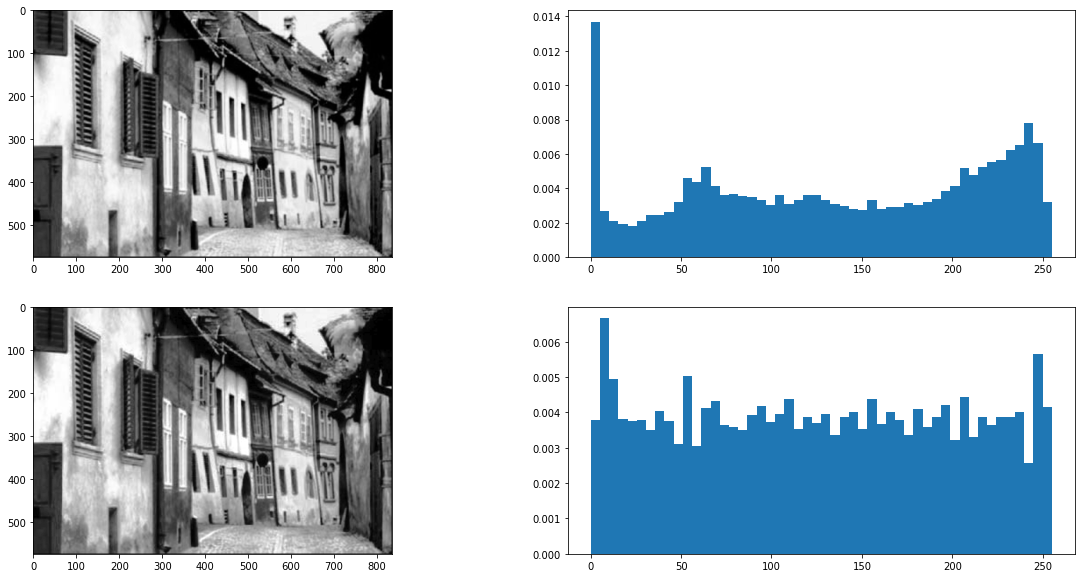

In [ ]:
# Read in an image, convert to gray valued, plot the (normalized) histogram of pixel gray values
# Notice how the distribution is NOT a Gaussian distribution. One could argue for 3 
# 4 peaks in this particular image.

# Import Open CV package
import cv2

# Load an color image in grayscale
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/house_facade.png')

# Change color spaces. Can experiment with other spaces.
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("Input image size:", img.shape)

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(img, 'gray');
plt.subplot(2,2,2)
# plot histogram
plt.hist(img.reshape(-1), bins=50, density=True);

out = cv2.equalizeHist(img)

plt.subplot(2,2,3)
plt.imshow(out, 'gray');
plt.subplot(2,2,4)
plt.hist(out.reshape(-1), bins=50, density=True);



#Segmentation

The goal of image segmentation is to group the pixels in the images into a set of disjoint regions, such that each region is most likely to come from a single object. This process is called partitioning an image. These elementary regions can then become units for further processing to group them into part and then into objects.

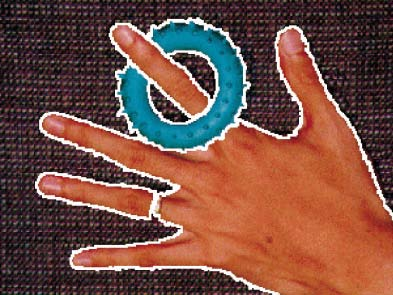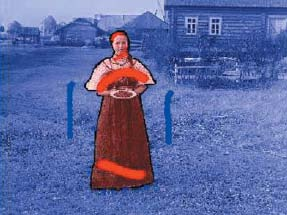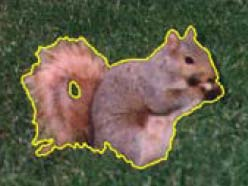


# Segmentation using K Means

K-means implicitly models a collection of features, e.g. colors of a pixel, as composed of k-buckets. Each bucket is associated with a mean value. Any data point is associated with its *nearest* mean value. It then iteratively updates the cluster center location based on the samples that are closest to each center. 

The algorithm can be initialized by randomly sampling k centers from the input feature vectors. 

Making K-Means "work" in real life data takes from fine tunning of the initialization step and monitoring the cluster centers, making sure they do not merge with each one.

Note that k-means implicitly assumes that the underlying probability density  is a superposition of spherically symmetric distributions (balls). 

There are lots of variation of K-Means
https://en.wikipedia.org/wiki/K-means_clustering



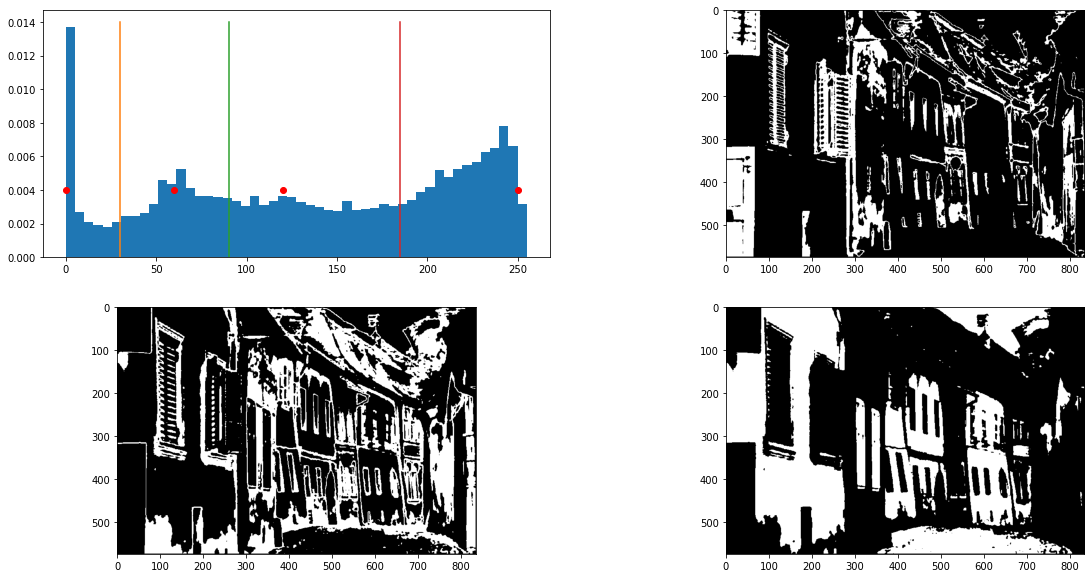

In [ ]:
# 1D Example

# NORMALIZED histogram

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.hist(img.reshape(-1), bins=50, density=True);

#Let the cluster means be
mu = [0, 60, 120, 250]
#the the boundaries of the clusters will be
border = [30, 90, 185]

plt.plot (mu, 0.004*np.ones(4), 'ro')
plt.plot ([border[0], border[0]], [0, 0.014]); 
plt.plot ([border[1], border[1]], [0, 0.014]); 
plt.plot ([border[2], border[2]], [0, 0.014]); 

plt.subplot(2,2,2)
plt.imshow ((img < 90) & (img > 30), 'gray')
plt.subplot(2,2,3)
plt.imshow ((img > 90) & (img < 185), 'gray')
plt.subplot(2,2,4)
plt.imshow ((img >= 185), 'gray')

# K Means

Given an initial set of k means, $\{ \mu_1,\cdots,\mu_k\}$, the algorithm proceeds by alternating between two steps:

1. *Assignment step:* Each observation is assigned to the nearest mean.

2. *Update step*: Recalculate means (centroids) for observations assigned to each cluster.

We stop when the assignments no longer changes. There is no guarantee of optimality of any kind.

Using a different distance function other than (squared) Euclidean distance may prevent the algorithm from converging. 




In [ ]:
def nD_k_Means (data, n_classes) :
    # nD K Means  -- 
    # data is a 2D tensor n_data by n_dim in size. Each row is a data vector.
    # returns the 2D tensor n_data by 1 vector assigning a data point to one of the n_classes
    # along with the mean value of each class.

    n_dim = data.shape[1];
    n_data = data.shape[0];

    # -- initialization -- randomly select points in the range
    data_max, ind = torch.max(data, 0)
    data_min, ind = torch.min(data, 0)
    mu = torch.zeros(n_classes, n_dim).cuda() 
    # randomly pick n_classes points from the data a initial means
    mu = data [torch.randint(n_data, (n_classes,)), :] 
    

    #print("\n mu=", mu.shape, mu)
    for i in range (20): 
        # -- Assignment-step-------------------------
        distances = (data[:, None, :] - mu[None, :,  :])**2
        distances = distances.sum(2) #n_data by n_classes array of distances from each of the K means 
        val, ind = torch.min(distances, 1)
        Z = torch.zeros((n_data, n_classes)).cuda ()
        
        Z[torch.arange(n_data,), ind] = 1

        #print(Z.shape, Z)
        
        #--- Mean computation step

        N = torch.sum(Z, 0)
        #print("\n N=", N[:,None], data[:,None,:], Z[:,:,None])

        mu = (data[:,None,:] * Z[:,:,None]).sum(0)/N[:,None]
        # data is n_data by n_dim and Z is n_data by n_classes, using inserting empty dimension to make
        # data to n_data by 1 by n_dim  and Z to be n_data by n_classes by 1 tensor
        # Broadcasting using operations results in a n_data by n_classes by n_dim tensor
        # Then we sum over the first dimension to result in a n_classes by n_dim tensor of mean values
        # Normalization is by N which is expanded to n_classes by 1 tensor and then broadcasted during operations

    # Display results
    val, ind = torch.max(Z, 1)
    print("\n mu=", mu.shape, mu)

    return(ind, mu)


In [ ]:
def show_pixel_scatter (pixels, ax, c = 'r', n_plot = 1000) : # 2D array of pixel values, one pixel per row
  #fig = plt.figure()
  # ax = fig.add_subplot(111, projection='3d')
  rand_pixels = pixels[np.random.choice(pixels.shape[0], n_plot, replace=False), :]
  ax.scatter(rand_pixels[:,0], rand_pixels[:,1], rand_pixels[:,2], c)
  ax.set_xlabel('Channel 1')
  ax.set_ylabel('Channel 2')
  ax.set_zlabel('Channel 3')

def reduce_size (img, scale_percent = 20) :
  #calculate the scale_percent of original dimensions
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  # resize image
  return (cv2.resize(img, (width, height)))


Input image size: (575, 835, 3)

 mu= torch.Size([5, 3]) tensor([[ 52.6865,  41.7290, 130.3924],
        [169.1170, 188.9726, 197.6595],
        [ 11.7102,  12.5559,  24.9501],
        [114.4421, 118.8836, 144.6191],
        [231.4583, 232.4855, 229.6381]], device='cuda:0')
CPU times: user 103 ms, sys: 2.97 ms, total: 106 ms
Wall time: 106 ms
Reduced image size: (575, 835, 3)
torch.Size([575, 835, 3])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


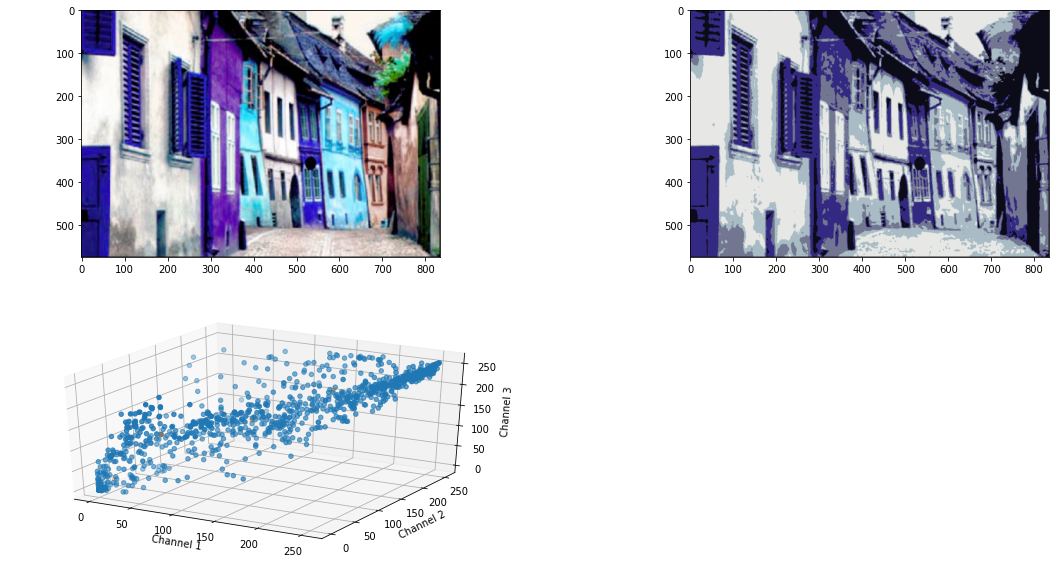

In [ ]:
import cv2

# Load an color image in grayscale
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/house_facade.png')

# Change color spaces. Can experiment with other color spaces.
#img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
print("Input image size:", img.shape)

#img = reduce_size(img, scale_percent=50)
pixels = np.float32(img.reshape((-1,3))) # change the shape of the 2D image into a 1D array

##------------------
%time X, mu = nD_k_Means (torch.tensor(pixels).cuda (), 5)
##------------------


fig = plt.figure (figsize=(20,10))  
plt.subplot(2,2,1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_LAB2BGR))
plt.imshow (img)
print("Reduced image size:", img.shape)


labels = mu[X,:].cpu ()

labels = labels.reshape((img.shape[0], img.shape[1], img.shape[2]))
print(labels.shape)
plt.subplot(2,2,2)
# plt.imshow(cv2.cvtColor(labels.cpu().numpy(), cv2.COLOR_LAB2BGR))
plt.imshow (labels.cpu().numpy()/255.0)

plt.subplot(2,2,3)
ax = plt.subplot(2,2,3,projection='3d')

show_pixel_scatter (pixels, ax, 'b', n_plot = 1000)
show_pixel_scatter (mu.cpu(), ax, c='r*', n_plot = mu.shape[0])

# Worksheet

Assume, n_data = 5, n_dim = 2, and n_classes = 3 and create one example instance for each of the following variables: data, Z, and N

Using this example, illustrate the working of the "broadcasting" methods used in following line of the ND_k_Means code discussed above 

mu = (data[:,None,:] * Z[:,:,None]).sum(0)/N[:,None]



